In [1]:
device = "mps"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
from ml_zoo import MNISTDataModule, MNISTDataModuleConfig

In [3]:
dm = MNISTDataModule(
    MNISTDataModuleConfig(
        "data",
        batch_size=128,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        transforms=[torchvision.transforms.ToTensor(), torchvision.transforms.Resize((32, 32))],
    )
)
dm.prepare_data()
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 32 * 32)

        class_embs = nn.Embedding(10, 100)

    def forward(self, x, y):
        class_emb = self.class_embs(y)
        x += class_emb
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.leaky_relu(self.fc4(x), 0.2)
        x = torch.tanh(self.fc5(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

        

    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x
    
G = Generator()
D = Discriminator()

print(f"Models have {sum(p.numel() for p in G.parameters()):,} in G and {sum(p.numel() for p in D.parameters()):,} in D")

Models have 1,752,448 in G and 1,705,985 in D



In [5]:
@torch.no_grad()
def eval():
    G.eval()
    D.eval()
    G_loss = 0
    D_loss = 0
    for x, _ in val_loader:
        x = x.view(x.size(0), -1)
        z = torch.randn(x.size(0), 100)
        fake = G(z)
        real = D(x)
        fake_loss = G.loss(D(fake))
        real_loss = D.loss(real, torch.ones(x.size(0), 1))
        G_loss += fake_loss.item()
        D_loss += real_loss.item()
    G.train()
    D.train()
    return G_loss / len(val_loader), D_loss / len(val_loader)

In [8]:
optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# G_roll = 0
# D_roll = 0

roll = 0.9

ones = torch.ones(128, 1)
zeros = torch.zeros(128, 1)

for epoch in range(100):
    pbar = tqdm.tqdm(train_loader)
    for x, y in pbar:
        # Train D
        x = x.flatten(1)
        z = torch.randn(x.size(0), 100)
        fake = D(G(z))
        real = D(x)
        fake_loss = F.binary_cross_entropy(fake, zeros[:x.size(0)])
        real_loss = F.binary_cross_entropy(real, ones[:x.size(0)])
        D_loss = (fake_loss + real_loss) / 2
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        D_roll = roll * D_roll + (1 - roll) * D_loss.item()

        # Train G
        z = torch.randn(x.size(0), 100)
        fake = G(z)
        G_loss = F.binary_cross_entropy(D(fake), ones[:x.size(0)])
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        G_roll = roll * G_roll + (1 - roll) * G_loss.item()

        pbar.set_postfix_str(f"G: {G_roll:.4f}, D: {D_roll:.4f}")

    G_loss, D_loss = eval()
    print(f"Epoch {epoch} G: {G_loss:.4f}, D: {D_loss:.4f}")

100%|██████████| 469/469 [00:13<00:00, 33.61it/s, G: 4.6932, D: 0.2083]


AttributeError: 'Generator' object has no attribute 'loss'

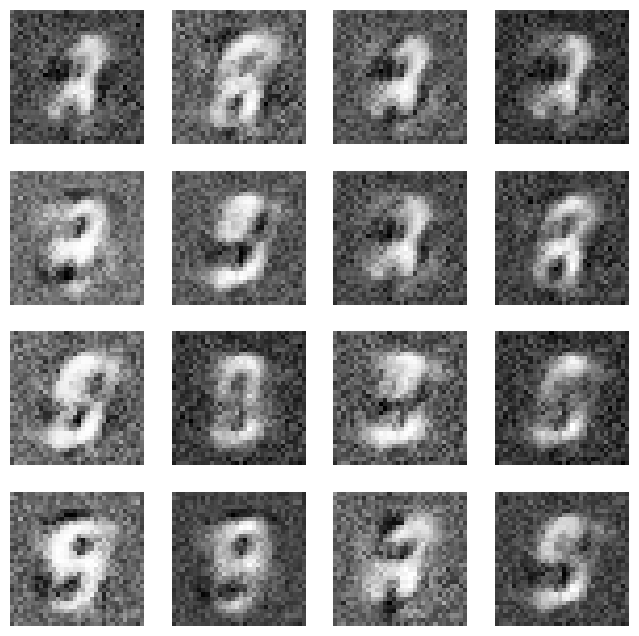

In [7]:
# sample and plot images
import matplotlib.pyplot as plt

G.eval()
z = torch.randn(16, 100)
images = G(z).view(-1, 32, 32).detach().cpu().numpy()

images = (images + 1) / 2

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")
plt.show()